In [1]:
pip install tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
IMG_SIZE = 224
BATCH_SIZE = 32
NO_EPOCHS = 20
NUM_CLASSES = 2
DATA_FOLDER = "C:/Users/CCL/Desktop/ODIR-5K/Training Images"
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import cv2 as cv
from random import shuffle 
from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
# from keras.utils import plot_model
from keras.applications.resnet import ResNet50
from tensorflow.keras import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
import tensorflow_addons as tfa
import tensorflow as tf
%matplotlib inline 
#from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.display import SVG

C:\Users\CCL\CONDA\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [7]:
data_df = pd.read_excel(open("data.xlsx", 'rb'), sheet_name='Sheet1')

In [8]:
data_df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0


In [9]:
data_df.columns = ["id", 'age', "sex", "left_fundus", "right_fundus", "left_diagnosys", "right_diagnosys", "normal",
                  "diabetes", "glaucoma", "cataract", "amd", "hypertension", "myopia", "other"]

In [10]:
print(data_df.loc[(data_df.cataract==1)].shape)
print(data_df.loc[data_df.cataract==0].shape)

(212, 15)
(3288, 15)


In [11]:
data_df.loc[(data_df.cataract==1)]['left_diagnosys'].value_counts()

cataract                                                                   135
normal fundus                                                               24
cataract，lens dust                                                           8
moderate non proliferative retinopathy                                       6
lens dust，cataract                                                           5
mild nonproliferative retinopathy                                            5
lens dust，normal fundus                                                      4
cataract，moderate non proliferative retinopathy                              3
refractive media opacity                                                     3
normal fundus，lens dust                                                      3
severe proliferative diabetic retinopathy                                    2
cataract，mild nonproliferative retinopathy                                   2
drusen，cataract，lens dust                           

In [12]:
data_df.loc[(data_df.cataract==1)]['right_diagnosys'].value_counts()


cataract                                                                  127
normal fundus                                                              24
moderate non proliferative retinopathy                                      9
cataract，lens dust                                                          6
drusen                                                                      5
lens dust，cataract                                                          5
mild nonproliferative retinopathy                                           4
refractive media opacity                                                    4
macular epiretinal membrane                                                 3
epiretinal membrane                                                         3
cataract，moderate non proliferative retinopathy                             3
moderate non proliferative retinopathy，cataract                             3
hypertensive retinopathy，cataract                               

In [13]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0

In [14]:
data_df['le_cataract'] = data_df['left_diagnosys'].apply(lambda x: has_cataract_mentioned(x))
data_df['re_cataract'] = data_df['right_diagnosys'].apply(lambda x: has_cataract_mentioned(x))

In [15]:
cataract_le_list = data_df.loc[(data_df.cataract==1) & (data_df.le_cataract==1)]['left_fundus'].values
cataract_re_list = data_df.loc[(data_df.cataract==1) & (data_df.re_cataract==1)]['right_fundus'].values
print(len(cataract_le_list), len(cataract_re_list))
non_cataract_le_list = data_df.loc[(data_df.cataract==0) & (data_df.left_diagnosys=="normal fundus")]['left_fundus'].sample(150, random_state=314).values
non_cataract_re_list = data_df.loc[(data_df.cataract==0) & (data_df.right_diagnosys=="normal fundus")]['right_fundus'].sample(150, random_state=314).values
print(len(non_cataract_le_list), len(non_cataract_re_list))

159 154
150 150


In [16]:
cataract_list = np.concatenate((cataract_le_list, cataract_re_list), axis = 0)
non_cataract_list = np.concatenate((non_cataract_le_list, non_cataract_re_list), axis = 0)
print(len(non_cataract_list), len(cataract_list))

300 313


In [17]:
print(len(os.listdir(DATA_FOLDER)))

7000


In [18]:
def label_image(label):
    if label == 1:
        return [1,0]
    elif label == 0: 
        return [0,1]

def process_data(data_image_list, DATA_FOLDER, is_cataract):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        label = label_image(is_cataract)
        img = cv.imread(path,cv.IMREAD_COLOR)
        img = cv.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

In [19]:
cat_df = process_data(cataract_list, DATA_FOLDER, 1)

100%|████████████████████████████████████████████████████████████████████████████████| 313/313 [00:17<00:00, 17.48it/s]


In [20]:
cat_no_df = process_data(non_cataract_list, DATA_FOLDER, 0)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 11.02it/s]


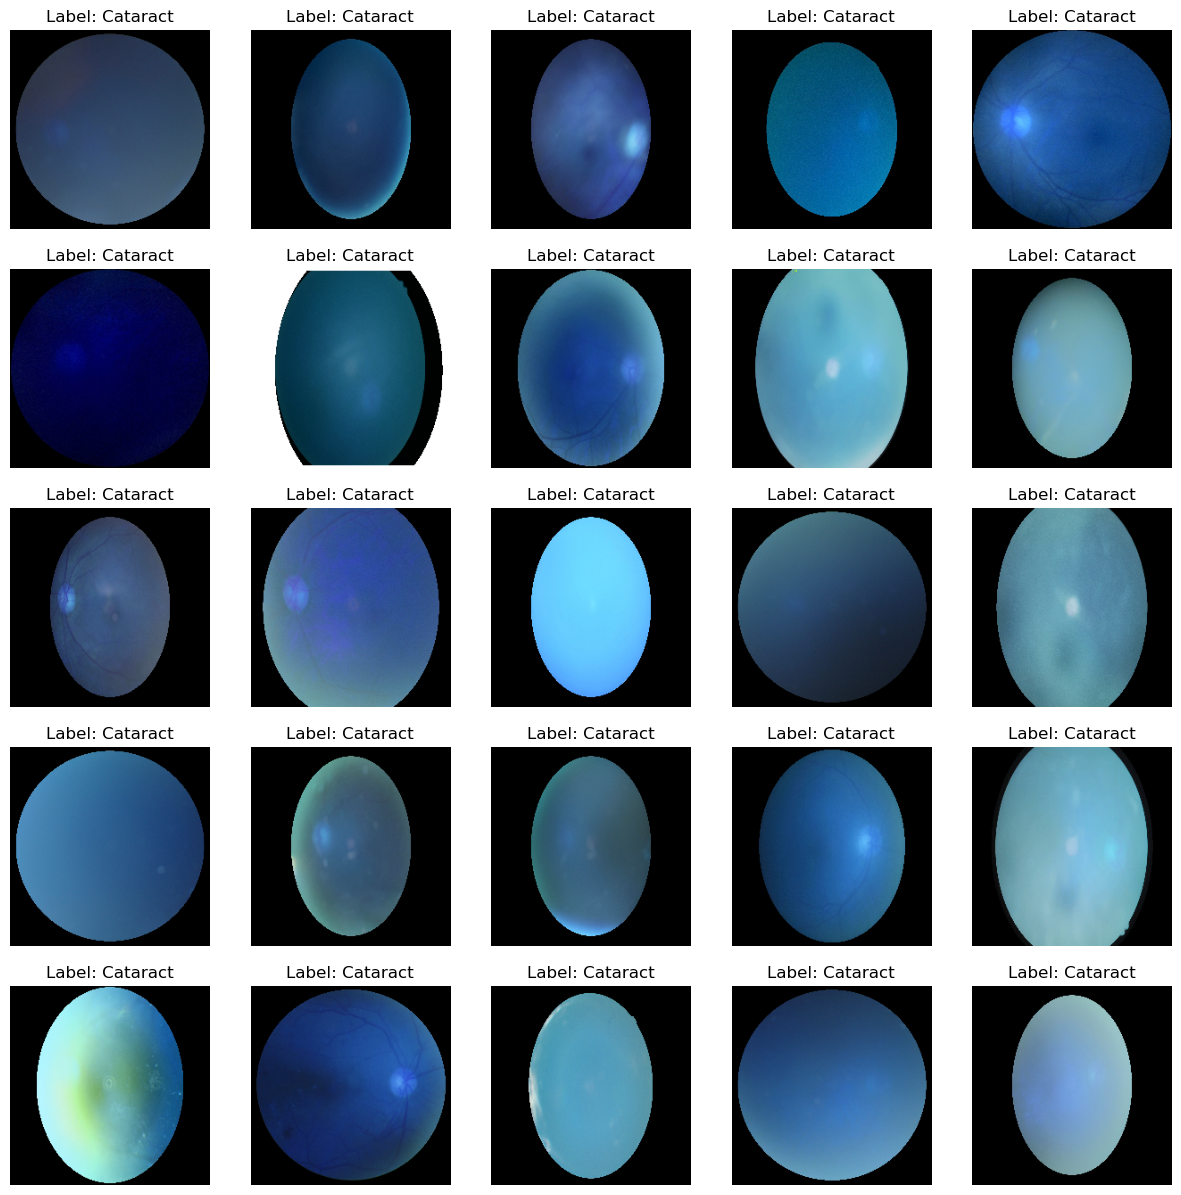

In [21]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 0: 
            str_label='Cataract'
        elif label == 1: 
            str_label='No Cataract'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(cat_df)


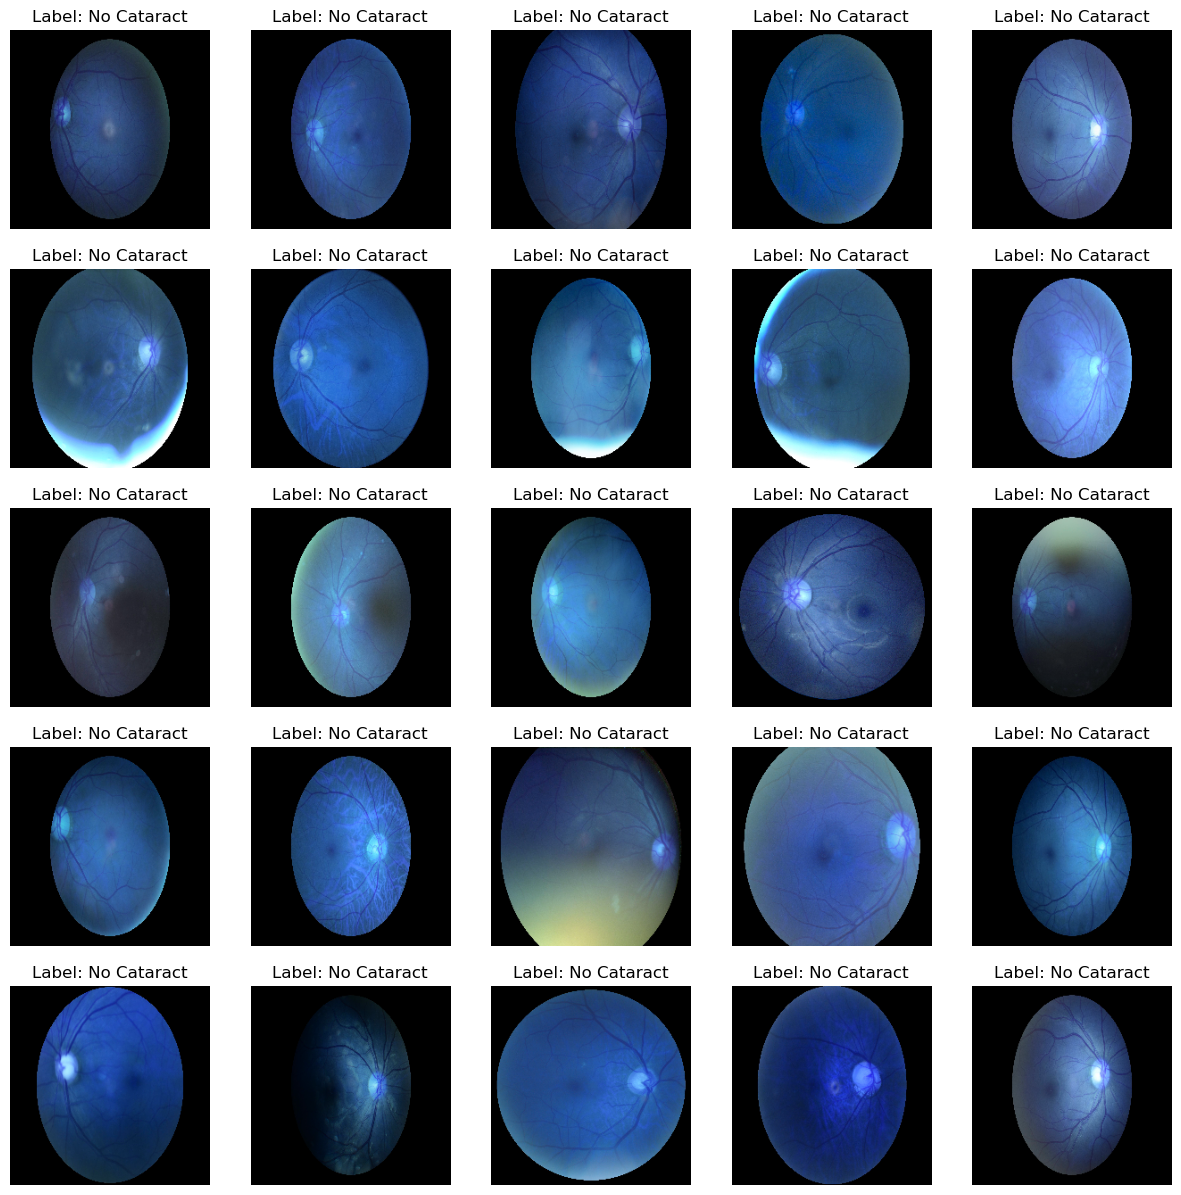

In [22]:
show_images(cat_no_df)

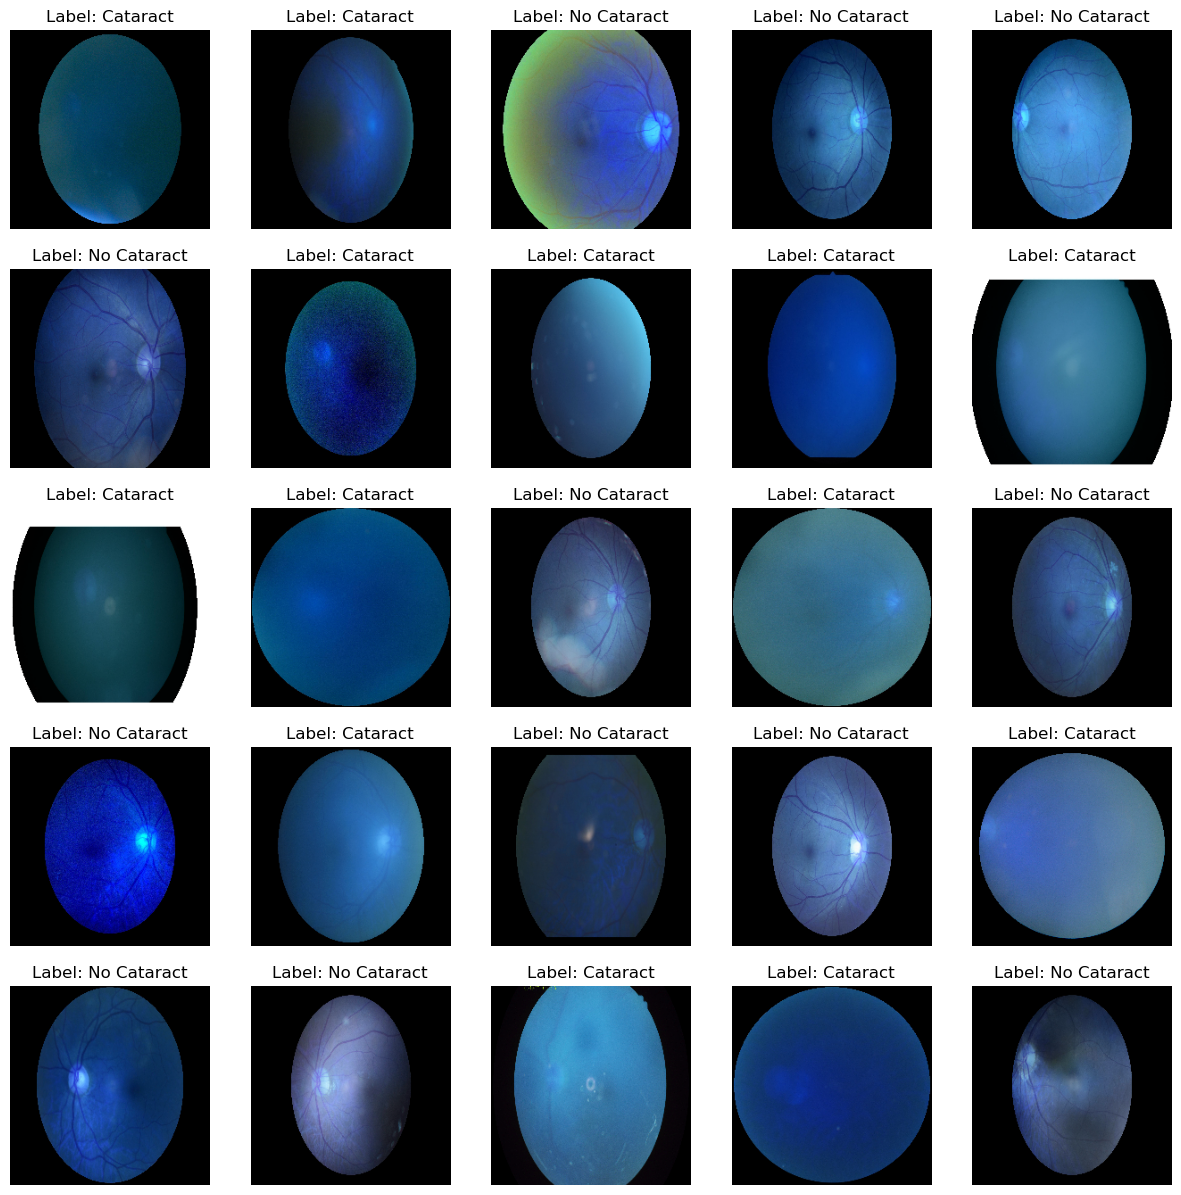

In [23]:
train = cat_df + cat_no_df
shuffle(train)
show_images(train)

In [24]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

In [25]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True


In [26]:
opt = tfa.optimizers.LazyAdam()
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.025)
model.compile(optimizer='sgd', loss=loss, metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper (ModuleWrap  (None, 2)                 4098      
 per)                                                            
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 23538690 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [28]:
pip install pydotplus

Note: you may need to restart the kernel to use updated packages.


In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [30]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/20
16/16 [==============================] - 122s 5s/step - loss: 27.4739 - accuracy: 0.5959 - val_loss: 411963.9688 - val_accuracy: 0.4878
Epoch 2/20
16/16 [==============================] - 72s 4s/step - loss: 4.4950 - accuracy: 0.7122 - val_loss: 91100.6484 - val_accuracy: 0.5122
Epoch 3/20
16/16 [==============================] - 74s 5s/step - loss: 1.4676 - accuracy: 0.8184 - val_loss: 35893.8789 - val_accuracy: 0.5122
Epoch 4/20
16/16 [==============================] - 74s 5s/step - loss: 1.5051 - accuracy: 0.8224 - val_loss: 3337.8545 - val_accuracy: 0.5122
Epoch 5/20
16/16 [==============================] - 73s 5s/step - loss: 0.9521 - accuracy: 0.8000 - val_loss: 2.2627 - val_accuracy: 0.5122
Epoch 6/20
16/16 [==============================] - 71s 4s/step - loss: 0.8095 - accuracy: 0.8531 - val_loss: 51.9583 - val_accuracy: 0.5203
Epoch 7/20
16/16 [==============================] - 70s 4s/step - loss: 0.2541 - accuracy: 0.9265 - val_loss: 19.1497 - val_accuracy: 0.5366


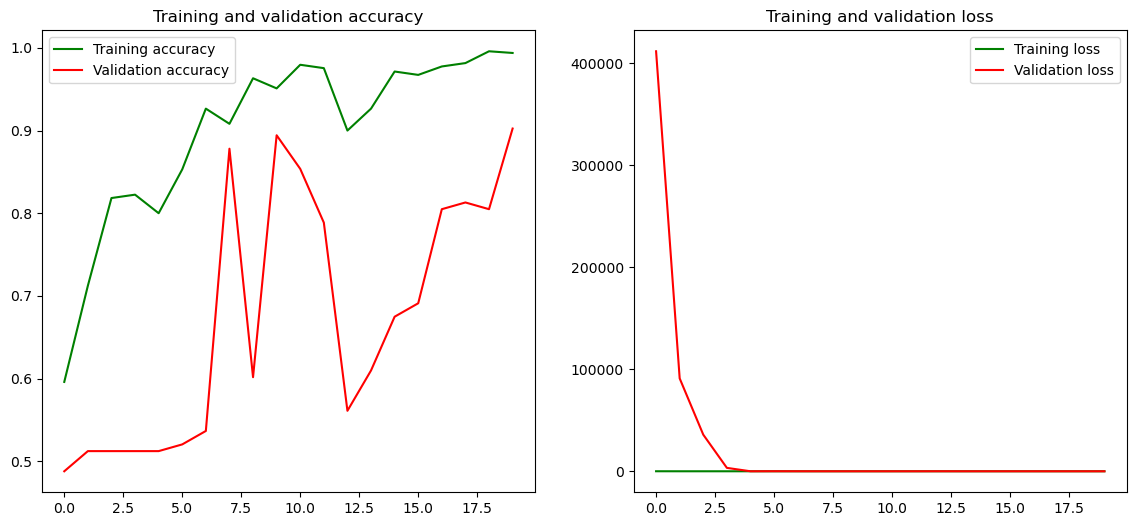

In [31]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

In [32]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.31865137815475464
Validation accuracy: 0.9024389982223511


In [33]:
# Get the predictions for the test data
predicted_probs = model.predict(X_val)
predicted_classes = np.argmax(predicted_probs, axis=1)

# Get the indices to be plotted
y_true = np.argmax(y_val, axis=1)


4/4 [==============================] - 5s 950ms/step


In [34]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [35]:
target_names = ["Cataract", "Normal"]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Cataract       0.86      0.97      0.91        63
      Normal       0.96      0.83      0.89        60

    accuracy                           0.90       123
   macro avg       0.91      0.90      0.90       123
weighted avg       0.91      0.90      0.90       123

